[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/ersip-sprint/blob/master/sprints/3/pattern_spectrum_building_detection.ipynb)

### Multi-Attribute Profiling for Building Delineation

This notebook performs multi-attribute profiling using area, compactness, moment of inertia, and standard deviation for building detection in drone images

In [ ]:
import matplotlib.pyplot as plt
from src.profile import (
    load_drone_image,
    compute_tree_attributes,
    compute_2d_pattern_spectra,
    visualize_pattern_spectra,
    visualize_filtering_results,
    process_drone_image,
    batch_process_images
)
import sap


/home/krschap/academia/ersip-sprint/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
! wget 'https://oin-hotosm-temp.s3.us-east-1.amazonaws.com/669a3a711684770001c33a8f/0/669a3a711684770001c33a90.tif' -O drone_image_1.tif
! wget 'https://oin-hotosm-temp.s3.us-east-1.amazonaws.com/693d326385300c176da53956/0/693d326385300c176da53957.tif'  -O drone_image_2.tif

--2025-12-16 15:56:52--  https://oin-hotosm-temp.s3.us-east-1.amazonaws.com/669a3a711684770001c33a8f/0/669a3a711684770001c33a90.tif
Resolving oin-hotosm-temp.s3.us-east-1.amazonaws.com (oin-hotosm-temp.s3.us-east-1.amazonaws.com)... 16.182.99.42, 16.15.202.21, 52.216.241.96, ...
Connecting to oin-hotosm-temp.s3.us-east-1.amazonaws.com (oin-hotosm-temp.s3.us-east-1.amazonaws.com)|16.182.99.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12315370 (12M) [binary/octet-stream]
Saving to: ‘drone_image_1.tif’

drone_image_1.tif   100%[===================>]  11.74M  1.16MB/s    in 15s     

2025-12-16 15:57:10 (782 KB/s) - ‘drone_image_1.tif’ saved [12315370/12315370]

--2025-12-16 15:57:10--  https://oin-hotosm-temp.s3.us-east-1.amazonaws.com/693d326385300c176da53956/0/693d326385300c176da53957.tif
Resolving oin-hotosm-temp.s3.us-east-1.amazonaws.com (oin-hotosm-temp.s3.us-east-1.amazonaws.com)... 52.216.42.242, 16.182.105.90, 54.231.136.74, ...
Connecting to oin-h

Image 1 shape: (1902, 2038)
Image 2 shape: (4839, 4483)


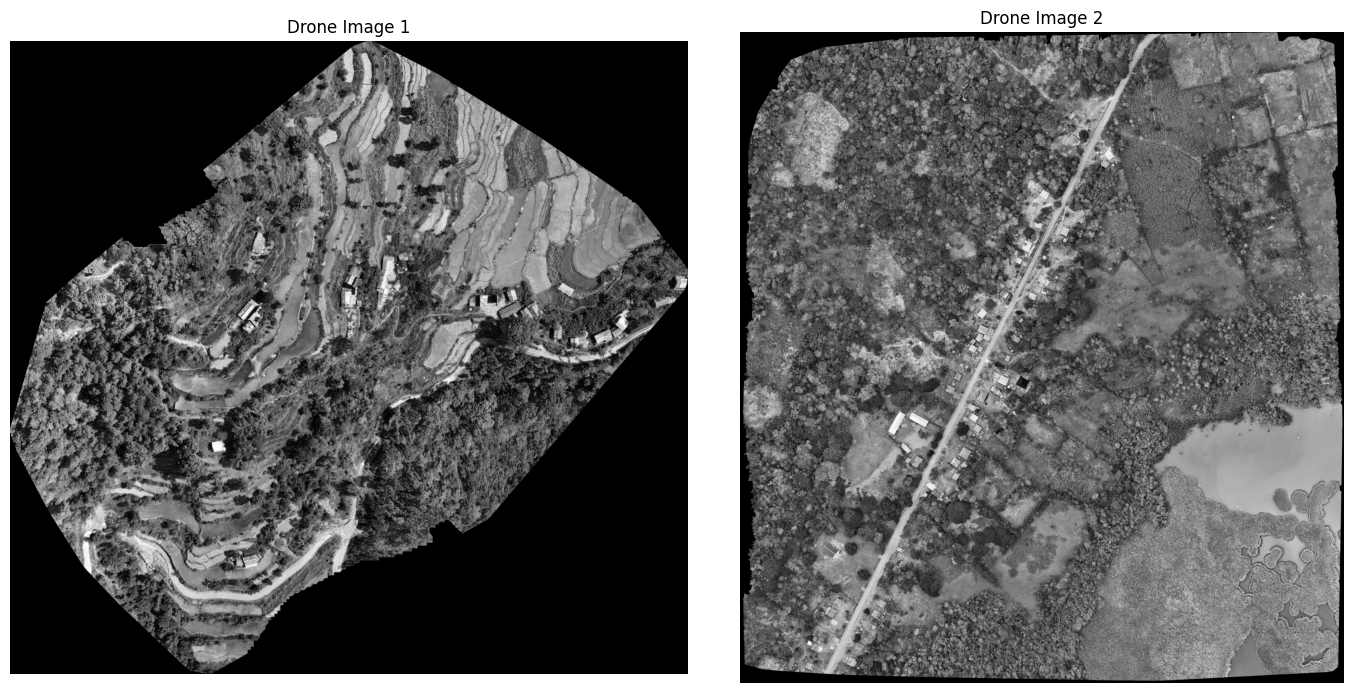

In [2]:
downsample = 4
img1 = load_drone_image('drone_image_1.tif', downsample_factor=downsample)
img2 = load_drone_image('drone_image_2.tif', downsample_factor=downsample)

print(f'Image 1 shape: {img1.shape}')
print(f'Image 2 shape: {img2.shape}')

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(img1, cmap='gray')
axes[0].set_title('Drone Image 1')
axes[0].axis('off')
axes[1].imshow(img2, cmap='gray')
axes[1].set_title('Drone Image 2')
axes[1].axis('off')
plt.tight_layout()
plt.show()
     


### Compute Attributes 
Build max-tree and compute area, compactness, moment of inertia, and standard deviation.( std is not available in standard sap hence i have extended the library to enable this attribute profiling)

In [3]:
tree1 = sap.MaxTree(img1)
attrs1 = compute_tree_attributes(tree1, img1, include_std=True)

print(f'Nodes: {tree1.num_nodes()}')
print(f'Area: [{attrs1["area"].min():.0f}, {attrs1["area"].max():.0f}]')
print(f'Compactness: [{attrs1["compactness"].min():.3f}, {attrs1["compactness"].max():.3f}]')
print(f'Moment of Inertia: [{attrs1["moment_of_inertia"].min():.3f}, {attrs1["moment_of_inertia"].max():.3f}]')
print(f'Standard Deviation: [{attrs1["standard_deviation"].min():.3f}, {attrs1["standard_deviation"].max():.3f}]')

Nodes: 4410978
Area: [1, 3876276]
Compactness: [0.000, 1.000]
Moment of Inertia: [0.000, 4.044]
Standard Deviation: [0.000, 0.249]


### 2D Pattern Spectra

Here also standard deviation is not supported on the spectra computation and visualization so i extended this function as well 

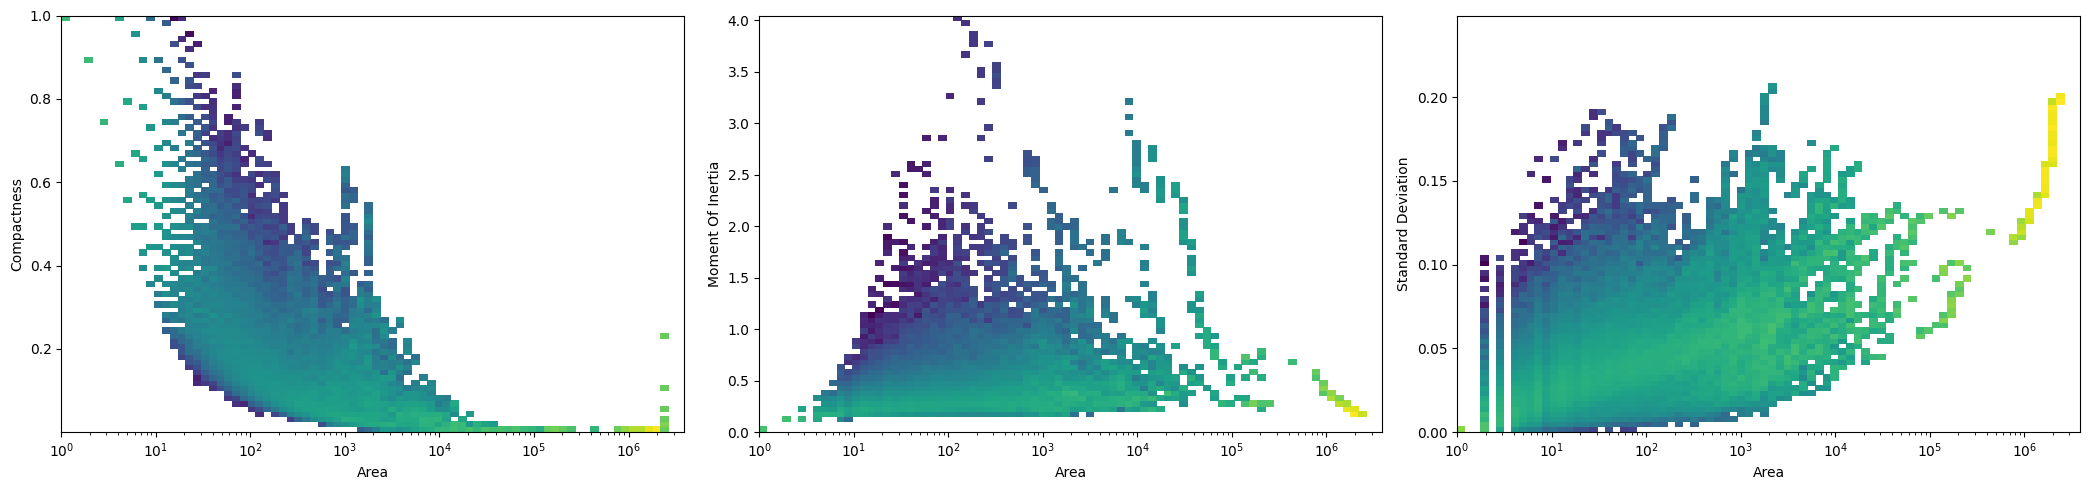

In [4]:
spectrum_pairs = [
    ('area', 'compactness'),
    ('area', 'moment_of_inertia'),
    ('area', 'standard_deviation')
]

spectra1 = compute_2d_pattern_spectra(tree1, spectrum_pairs, image=img1, x_log=True, y_log=False)
fig = visualize_pattern_spectra(spectra1, log_scale=True)
plt.show()

### Multi-Attribute Filtering

Apply thresholds 

Selected nodes: 504/4410978 (0.0%)


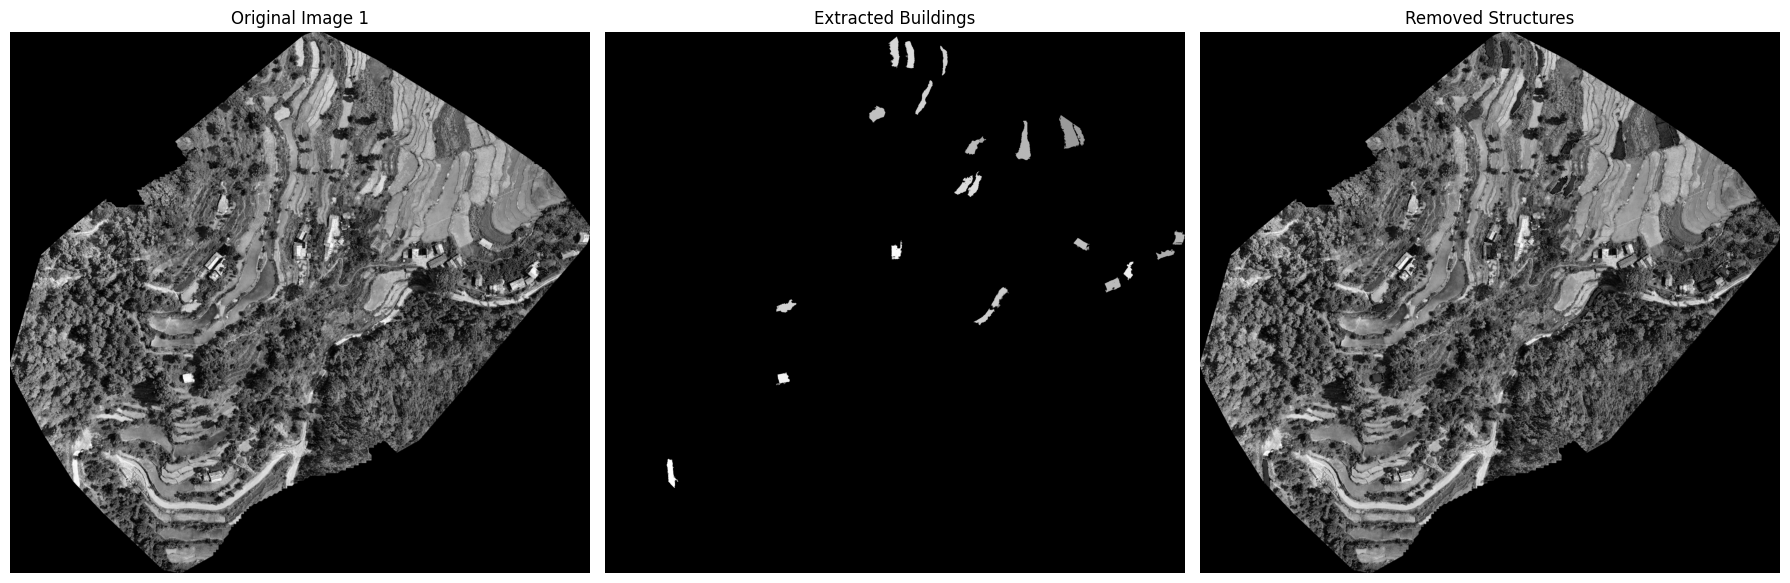

In [5]:
thresholds = {
    'area': (1000, 10000),
    'compactness': (0.20, 1.0),
    'moment_of_inertia': (0, 3000),
    'standard_deviation': (0.05, 0.5)
}

result1 = process_drone_image(
    img1, 
    thresholds, 
    tree_type='max',
    compute_spectra=False
)

print(f'Selected nodes: {result1["mask"].sum()}/{len(result1["mask"])} ({100*result1["mask"].sum()/len(result1["mask"]):.1f}%)')

fig = visualize_filtering_results(
    result1['image'], 
    result1['filtered'],
    titles=['Original Image 1', 'Extracted Buildings', 'Removed Structures']
)
plt.show()

### Batch Processing 
Process both drone image with same parameters to see how it performs 


Image 1:
  Selected nodes: 504/4410978 (0.0%)


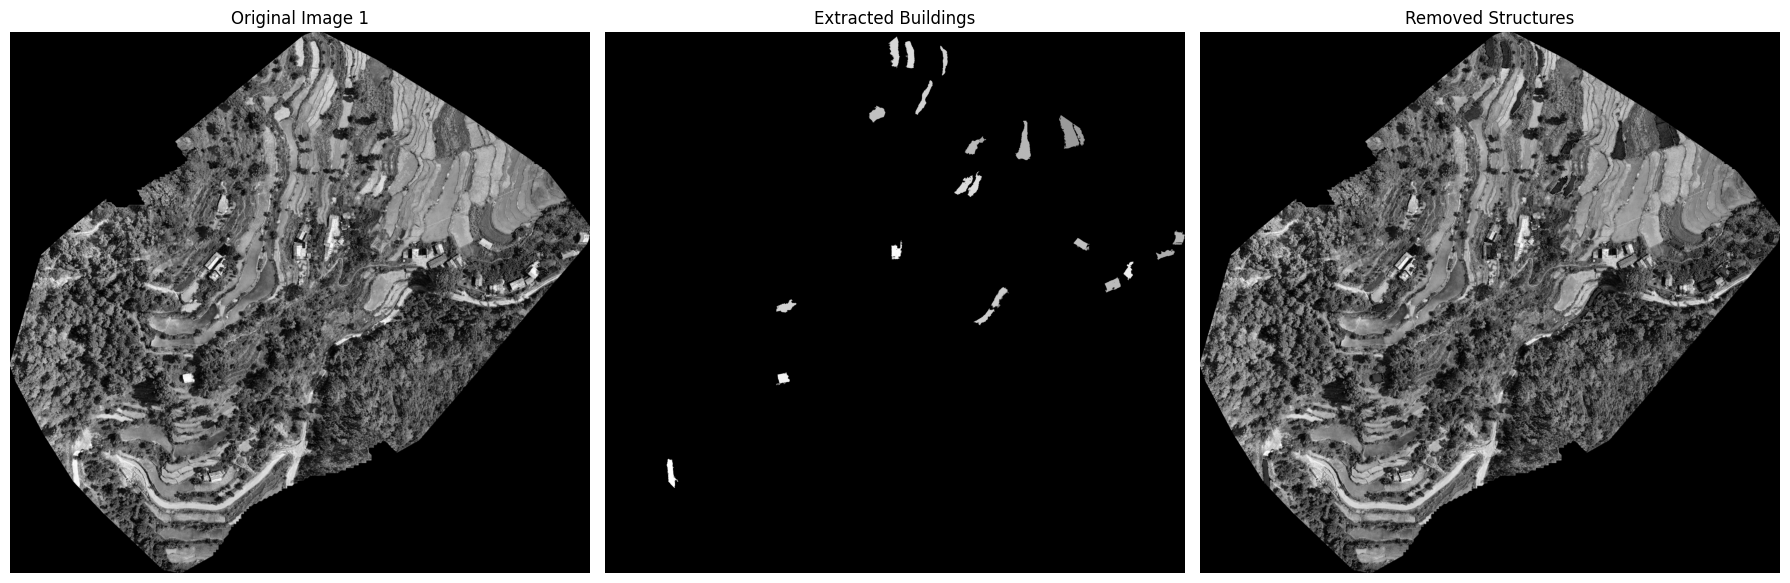


Image 2:
  Selected nodes: 404/28087714 (0.0%)


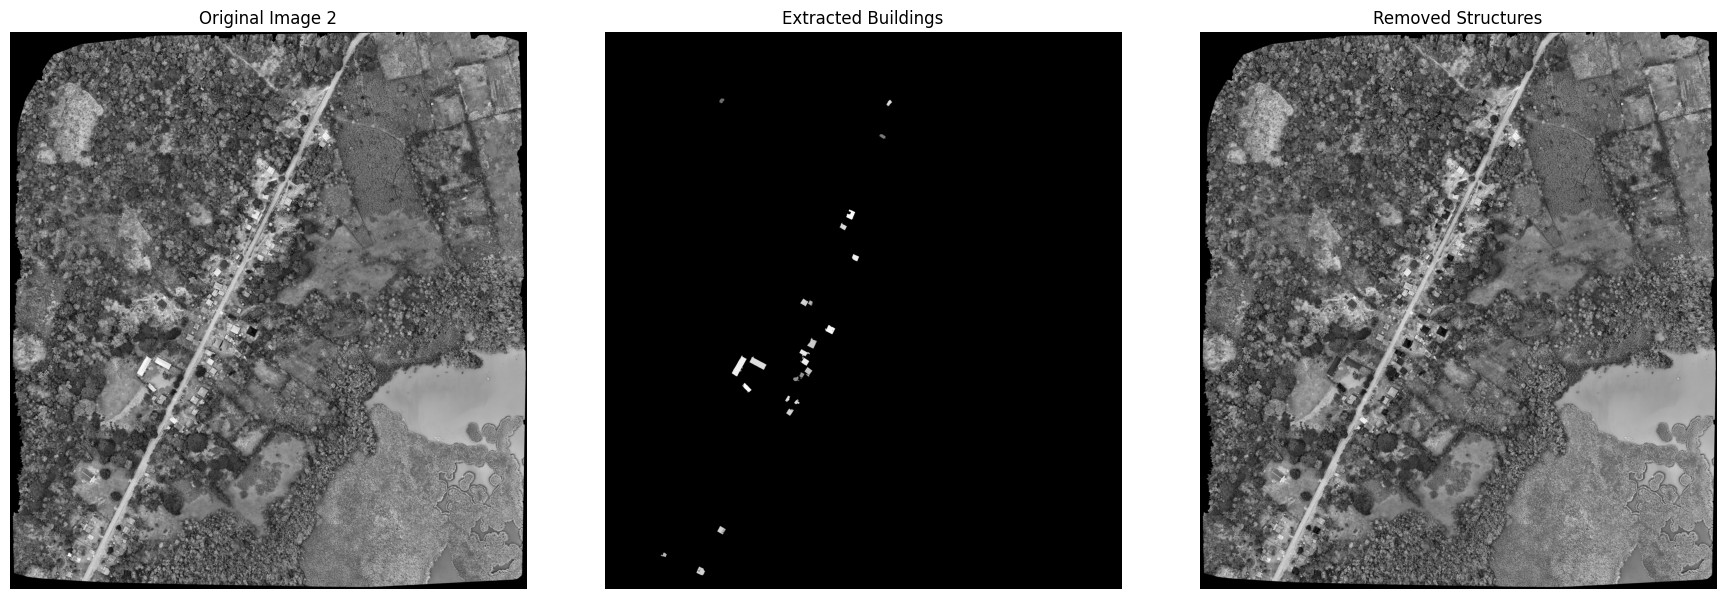

In [6]:
results = batch_process_images(
    [img1, img2],
    thresholds,
    tree_type='max',
    compute_spectra=False
)

for i, result in enumerate(results, 1):
    print(f'\nImage {i}:')
    print(f'  Selected nodes: {result["mask"].sum()}/{len(result["mask"])} ({100*result["mask"].sum()/len(result["mask"]):.1f}%)')
    
    fig = visualize_filtering_results(
        result['image'],
        result['filtered'],
        titles=[f'Original Image {i}', 'Extracted Buildings', 'Removed Structures']
    )
    plt.show()

### Playing with the parameters 

Trying to play with the threshold parameters to see how it differs 

In [ ]:
alternative_thresholds = {
    'area': (500, 15000),
    'compactness': (0.15, 1.0),
    'moment_of_inertia': (0, 5000),
    'standard_deviation': (0.03, 0.6)
}

result_alt = process_drone_image(
    img2,
    alternative_thresholds,
    tree_type='max'
)

print(f'Alternative filtering - Selected nodes: {result_alt["mask"].sum()}/{len(result_alt["mask"])} ({100*result_alt["mask"].sum()/len(result_alt["mask"]):.1f}%)')

fig = visualize_filtering_results(
    result_alt['image'],
    result_alt['filtered'],
    titles=['Original', 'Alternative Filtering', 'Removed']
)
plt.show()